## Neural Net, resut

In [372]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [373]:
# Inlezen van CSV-bestand
dataPositions = pd.read_csv('../data-train-sin/positions_xyz_128px_2024-03-05_full.csv')
dataCoordinates = pd.read_csv('../data-train-sin/red_ball_coordinates_128px_2024-03-05_full.csv')
dataPositions.shape, dataCoordinates.shape

((10543, 3), (10543, 14))

In [374]:
combined = pd.concat([dataCoordinates, dataPositions], axis=1)
# remove the rows with to more than 3 NaN values
combined = combined.dropna()
combined = combined

In [375]:
X = combined.iloc[:, :14] # select all rows and columns from 0 to 13
y = combined.iloc[:, 14:] # select x y z output columns

### Data Preprocessing

### Splitting the dataset into the Training set and Test set

In [376]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=42)

# Splitting the training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.01, random_state=42)


In [377]:
y_train.shape, y_val.shape, y_test.shape

((10158, 3), (103, 3), (104, 3))

In [378]:
from sklearn.preprocessing import MinMaxScaler

scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_val_scaled = scaler_y.transform(y_val)
y_test_scaled = scaler_y.transform(y_test)

X_train_scaled.shape[0], X_val_scaled.shape[0], X_test_scaled.shape[0]

(10158, 103, 104)

In [379]:
# show all the NaN values in the dataset
X_train_scaled

array([[0.16264428, 0.79793689, 0.42494399, ..., 0.36397985, 0.14127082,
        0.41729107],
       [0.33053515, 0.17536408, 0.25870052, ..., 0.48706206, 0.28932758,
        0.5832853 ],
       [0.09247114, 0.59655643, 0.46276853, ..., 0.13413098, 0.06568395,
        0.17812832],
       ...,
       [0.17721814, 0.45752427, 0.43017177, ..., 0.85831234, 0.63479334,
        0.43112392],
       [0.66579224, 0.32936893, 0.90067214, ..., 0.69353484, 0.9802591 ,
        0.15446686],
       [0.09356418, 0.45843447, 0.00567588, ..., 0.78070825, 0.03269587,
        0.99827089]])

### Hyperparameter tuning

In [380]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPRegressor

# Define a parameter grid for the MLPRegressor
param_grid = {
    'model__hidden_layer_sizes': [(100,), (150,), (200,)],
    'model__activation': ['identity', 'logistic', 'tanh', 'relu'],
    'model__solver': ['sgd', 'adam'],
    'model__learning_rate': ['constant', 'invscaling', 'adaptive'],
    'model__learning_rate_init': [0.001, 0.01, 0.1],
    'model__max_iter': [10000, 20000, 28000],
    'model__early_stopping': [True],
}

# Create a pipeline with an MLPRegressor model
pipeline = Pipeline([
    ('model', MLPRegressor(random_state=42))
])
model = MLPRegressor(hidden_layer_sizes=(200,), solver='adam', max_iter=10000, early_stopping=True, random_state=42, activation='logistic', learning_rate='constant', learning_rate_init=0.1)
# Perform a randomized search over the parameter grid
#{'model__solver': 'adam', 'model__max_iter': 10000, 'model__learning_rate_init': 0.01, 'model__learning_rate': 'constant', 'model__hidden_layer_sizes': (200,), 'model__early_stopping': True, 'model__activation': 'logistic'}
random_search = RandomizedSearchCV(pipeline, param_distributions=param_grid, n_iter=100, cv=5, n_jobs=-1, verbose=2, random_state=42)

#### Train the model

In [381]:
model.fit(X_train_scaled, y_train_scaled)

MLPRegressor(activation='logistic', early_stopping=True,
             hidden_layer_sizes=(200,), learning_rate_init=0.1, max_iter=10000,
             random_state=42)

#### Result of the hyperparameter tuning

In [382]:
#model = random_search.best_estimator_

In [383]:
#print('fBest parameters found:\n', random_search.best_params_)

#### Make Predictions

In [384]:
y_val_pred_scaled = model.predict(X_val_scaled)
y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled)

#### Evaluate the model

In [385]:
from utils.evaluate import evaluate_model

mse_val, mae_val, r2_val = evaluate_model(y_val, y_val_pred, "Validation")

Mean Squared Error on Validation Set: 0.6445671110092142
Mean Absolute Error on Validation Set: 0.5120020733071386
R2 Score on Validation set: 0.8474746724429657


In [386]:
y_test_pred_scaled = model.predict(X_test_scaled)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)

In [387]:
mse_test, mae_test, r2_test = evaluate_model(y_test, y_test_pred, "Test")

Mean Squared Error on Test Set: 0.5840545328267751
Mean Absolute Error on Test Set: 0.47847666203125455
R2 Score on Test set: 0.8747723416959944


#### Visualize the results
The test data is randomized so the plot won't show a clean trajectory

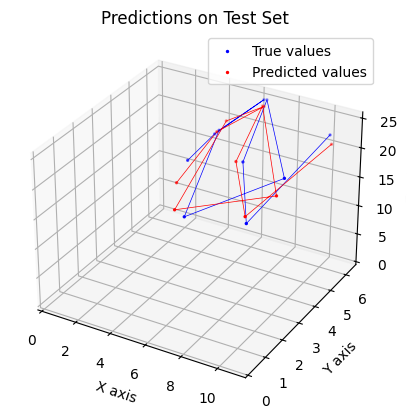

In [388]:
from utils.plot_maker import plot_maker_3d

plot_maker_3d(np.array(y_test)[:10], np.array(y_test_pred)[:10], "Predictions on Test Set")

# Make Predictions on new data

In [389]:
test_data = pd.read_csv('../data-test-sin/red_ball_coordinates_2024-03-05_12h01m.csv', delimiter=',', decimal='.')
test_result = pd.read_csv('../data-test-sin/positions_xyz_2024-03-05_12h01m.csv', delimiter=',', decimal='.')

In [390]:
new_combined = pd.concat([test_data, test_result], axis=1)
new_combined = new_combined.dropna()
new_combined = new_combined

In [391]:
new_X = new_combined.iloc[:, :14]
new_y = new_combined.iloc[:, 14:]
new_X.shape, new_y.shape

((1358, 14), (1358, 3))

In [392]:
new_X_scaled = scaler_X.fit_transform(new_X)
new_y_scaled = scaler_y.fit_transform(new_y)

In [393]:
new_y_pred_scaled = model.predict(new_X_scaled)

In [394]:
new_y_pred = scaler_y.inverse_transform(new_y_pred_scaled)

In [395]:
new_mse, new_mae, new_r2 = evaluate_model(new_y, new_y_pred, "New Data")

Mean Squared Error on New Data Set: 3.2071423053869412
Mean Absolute Error on New Data Set: 1.4173109744382109
R2 Score on New Data set: 0.2621169664636407


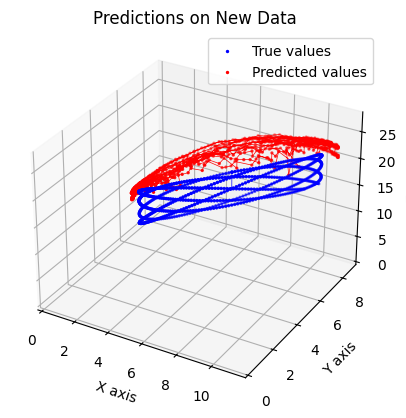

In [396]:
plot_maker_3d(np.array(new_y), np.array(new_y_pred), "Predictions on New Data")